In [2]:
#!pip install scikit-learn --force
#!pip install catboost

In [7]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os
import importlib

pd.set_option('display.max.columns', 300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastConfig
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
# Дата из который мы прогнозируем (пока что не меняется)
train_end = datetime(year=2023, month=8, day=31)

# Горизонт прогноза в месяцах
horizon = 3

In [9]:
# Данные для прогноза
scenario_data = {
    # Ожидаемый баланс на первую дату прогноза, задавать необязательно
     'expected_amount':      [np.nan for h in range(horizon)],
    # ССВ
     'SSV':                  [0.48 for h in range(horizon)],
    # ФОР
     'FOR':                  [4.5 for h in range(horizon)],
    # Трансфертные ставки
     'VTB_ftp_rate_[90d]':   [12.3 for h in range(horizon)],
     'VTB_ftp_rate_[180d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[365d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[548d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[730d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[1095d]': [12 for h in range(horizon)],
    
    # Маржа бизнеса по срочностям
     'margin_[90d]':         [0.1 for h in range(horizon)],
     'margin_[180d]':        [0.1 for h in range(horizon)],
     'margin_[365d]':        [0.1 for h in range(horizon)],
     'margin_[548d]':        [0.1 for h in range(horizon)],
     'margin_[730d]':        [0.2 for h in range(horizon)],
     'margin_[1095d]':       [0.2 for h in range(horizon)],
    
    # Спред Привилегия - Массовый (на сколько в среднем ставки по сегменту Привилегия больше чем ставки по массовому сегменту)
     'priv_spread':          [0.4 for h in range(horizon)],
    # Спред ВИП - Массовый (на сколько в среднем ставки по сегменту ВИП больше чем ставки по массовому сегменту)
     'vip_spread':           [0.8 for h in range(horizon)],
    
    # Ниже три спреда по разным типам опциональности по отношению к безопциональным вкладам (Подразумевается, что они, как правило, отрицательные)
    # r - возможности пополнения, s - возможность расходных операций
    
    # На сколько ставка по расходным вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r0s1_spread':          [-1 for h in range(horizon)],
    
    # На сколько ставка по пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s0_spread':          [-1 for h in range(horizon)],
    
    # На сколько ставка по расходно-пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s1_spread':          [-1.2 for h in range(horizon)],
    
    # Ставка по лучшему предложению сбера
     'SBER_max_rate':        [11.2, 11.2, 11.2],
    
    # Базовая ставка по НС
     'SA_rate':              [5 for h in range(horizon)]
}
scenario_df_user = pd.DataFrame(scenario_data)

In [10]:
scenario_df = preprocess_scenario(scenario_df_user, train_end, horizon)

In [11]:
scenario_df

,expected_amount,SBER_max_rate,rate_sa_weighted,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],VTB_weighted_rate_[mass]_[r0s0]_[90d],VTB_weighted_rate_[mass]_[r0s0]_[180d],VTB_weighted_rate_[mass]_[r0s0]_[365d],VTB_weighted_rate_[mass]_[r0s0]_[548d],VTB_weighted_rate_[mass]_[r0s0]_[730d],VTB_weighted_rate_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s1]_[90d],VTB_weighted_rate_[mass]_[r0s1]_[180d],VTB_weighted_rate_[mass]_[r0s1]_[365d],VTB_weighted_rate_[mass]_[r0s1]_[548d],VTB_weighted_rate_[mass]_[r0s1]_[730d],VTB_weighted_rate_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r1s0]_[90d],VTB_weighted_rate_[mass]_[r1s0]_[180d],VTB_weighted_rate_[mass]_[r1s0]_[365d],VTB_weighted_rate_[mass]_[r1s0]_[548d],VTB_weighted_rate_[mass]_[r1s0]_[730d],VTB_weighted_rate_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s1]_[90d],VTB_weighted_rate_[mass]_[r1s1]_[180d],VTB_weighted_rate_[mass]_[r1s1]_[365d],VTB_weighted_rate_[mass]_[r1s1]_[548d],VTB_weighted_rate_[mass]_[r1s1]_[730d],VTB_weighted_rate_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[priv]_[r0s0]_[90d],VTB_weighted_rate_[priv]_[r0s0]_[180d],VTB_weighted_rate_[priv]_[r0s0]_[365d],VTB_weighted_rate_[priv]_[r0s0]_[548d],VTB_weighted_rate_[priv]_[r0s0]_[730d],VTB_weighted_rate_[priv]_[r0s0]_[1095d],VTB_weighted_rate_[priv]_[r0s1]_[90d],VTB_weighted_rate_[priv]_[r0s1]_[180d],VTB_weighted_rate_[priv]_[r0s1]_[365d],VTB_weighted_rate_[priv]_[r0s1]_[548d],VTB_weighted_rate_[priv]_[r0s1]_[730d],VTB_weighted_rate_[priv]_[r0s1]_[1095d],VTB_weighted_rate_[priv]_[r1s0]_[90d],VTB_weighted_rate_[priv]_[r1s0]_[180d],VTB_weighted_rate_[priv]_[r1s0]_[365d],VTB_weighted_rate_[priv]_[r1s0]_[548d],VTB_weighted_rate_[priv]_[r1s0]_[730d],VTB_weighted_rate_[priv]_[r1s0]_[1095d],VTB_weighted_rate_[priv]_[r1s1]_[90d],VTB_weighted_rate_[priv]_[r1s1]_[180d],VTB_weighted_rate_[priv]_[r1s1]_[365d],VTB_weighted_rate_[priv]_[r1s1]_[548d],VTB_weighted_rate_[priv]_[r1s1]_[730d],VTB_weighted_rate_[priv]_[r1s1]_[1095d],VTB_weighted_rate_[vip]_[r0s0]_[90d],VTB_weighted_rate_[vip]_[r0s0]_[180d],VTB_weighted_rate_[vip]_[r0s0]_[365d],VTB_weighted_rate_[vip]_[r0s0]_[548d],VTB_weighted_rate_[vip]_[r0s0]_[730d],VTB_weighted_rate_[vip]_[r0s0]_[1095d],VTB_weighted_rate_[vip]_[r0s1]_[90d],VTB_weighted_rate_[vip]_[r0s1]_[180d],VTB_weighted_rate_[vip]_[r0s1]_[365d],VTB_weighted_rate_[vip]_[r0s1]_[548d],VTB_weighted_rate_[vip]_[r0s1]_[730d],VTB_weighted_rate_[vip]_[r0s1]_[1095d],VTB_weighted_rate_[vip]_[r1s0]_[90d],VTB_weighted_rate_[vip]_[r1s0]_[180d],VTB_weighted_rate_[vip]_[r1s0]_[365d],VTB_weighted_rate_[vip]_[r1s0]_[548d],VTB_weighted_rate_[vip]_[r1s0]_[730d],VTB_weighted_rate_[vip]_[r1s0]_[1095d],VTB_weighted_rate_[vip]_[r1s1]_[90d],VTB_weighted_rate_[vip]_[r1s1]_[180d],VTB_weighted_rate_[vip]_[r1s1]_[365d],VTB_weighted_rate_[vip]_[r1s1]_[548d],VTB_weighted_rate_[vip]_[r1s1]_[730d],VTB_weighted_rate_[vip]_[r1s1]_[1095d]
2023-09-30,NaN,11.2,5.0,12.3,12.0,12.0,12.0,12.0,12.0,10.3665,10.08,10.08,10.08,9.98,9.98,9.3665,9.08,9.08,9.08,8.98,8.98,9.3665,9.08,9.08,9.08,8.98,8.98,9.1665,8.88,8.88,8.88,8.78,8.78,10.7665,10.48,10.48,10.48,10.38,10.38,9.7665,9.48,9.48,9.48,9.38,9.38,9.7665,9.48,9.48,9.48,9.38,9.38,9.5665,9.28,9.28,9.28,9.18,9.18,11.1665,10.88,10.88,10.88,10.78,10.78,10.1665,9.88,9.88,9.88,9.78,9.78,10.1665,9.88,9.88,9.88,9.78,9.78,9.9665,9.68,9.68,9.68,9.58,9.58
2023-10-31,NaN,11.2,5.0,12.3,12.0,12.0,12.0,12.0,12.0,10.3665,10.08,10.08,10.08,9.98,9.98,9.3665,9.08,9.08,9.08,8.98,8.98,9.3665,9.08,9.08,9.08,8.98,8.98,9.1665,8.88,8.88,8.88,8.78,8.78,10.7665,10.48,10.48,10.48,10.38,10.38,9.7665,9.48,9.48,9.48,9.38,9.38,9.7665,9.48,9.48,9.48,9.38,9.38,9.5665,9.28,9.28,9.28,9.18,9.18,11.1665,10.88,10.88,10.88,10.78,10.78,10.1665,9.88,9.88,9.88,9.78,9.78,10.1665,9.88,9.88,9.88,9.78,9.78,9.9665,9.68,9.68,9.68,9.58,9.58
2023-11-30,NaN,11.2,5.0,12.3,12.0,12.0,12.0,12.0,12.0,10.3665,10.08,10.08,10.08,9.98,9.98,9.3665,9.08,9.08,9.08,8.98,8.98,9.3665,9.08,9.

In [12]:
port_folder = '../data/portfolio_data'
portfolio = load_portfolio(train_end, port_folder)

FileNotFoundError: [Errno 2] No such file or directory: '../data/portfolio_data/portfolio_2023-08.csv'

In [ ]:
# если хотим обучить модели

from core.models.utils import run_spark_session
#spark = run_spark_session('check_calc')

spark = None #если без обучения

In [ ]:
folder = '../data/trained_models'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)


In [10]:
dir(DepositsCalculationType)

['CurrentAccounts',
 'Deposits',
 'SavingAccounts',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [11]:
ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

In [12]:
config: ForecastConfig = ForecastConfig(
    first_train_end_dt = train_end,
    horizon = horizon,
    trainers = DepositModels.trainers,
    data_loaders = DepositModels.dataloaders,
    calculator_type = DepositIterativeCalculator,
    calc_type = DepositsCalculationType,
    adapter_types = DepositModels.adapter_types,
    scenario_data = scenario_df,
    portfolio = portfolio
)
    
training_manager = TrainingManager(spark, config.trainers, folder, model_db)   
engine: ForecastEngine = ForecastEngine(spark, config, training_manager, overwrite_models=False)

In [13]:
# %%time
# engine.run_all()

In [15]:
# Депозиты
# portfolio_res = engine.calc_results['Deposits']['portfolio'] 
# agg_res = engine.calc_results['Deposits']['agg_data']

In [17]:
# engine.calc_results['Deposits']['portfolio'].head()

In [18]:
# engine.calc_results['Deposits']['agg_data'].head()

In [20]:
# engine.calc_results['SavingAccounts'] # накопительные счета

In [21]:
# engine.calc_results['CurrentAccounts'] # расчетные счета

## Калькулятор маржи

`agg_res` - используем как портфель  
`scenario_df` - используем для извлечения маржи  

Из всей суммы начисленных процентов выразим долю связанную с маржой и перемножим эту долю на начисленные проценты

Маржу рассчитываем из формулы по `weighted_rate`  

`VTB_weighted_rate_[segment]_[optionality]_[maturity] = VTB_ftp_rate_[maturity] - margin_[maturity] - SSV - FOR + optionality_spread + segment_spread`  

Откуда:  
`margin_[maturity] / VTB_weighted_rate_[segment]_[optionality]_[maturity] = (VTB_ftp_rate_[maturity] - SSV - FOR + optionality_spread + segment_spread) / VTB_weighted_rate_[segment]_[optionality]_[maturity] - 1`  


Умножаем interests на маржу для каждого:  
* сегмента  
* опциональности  
* срочности  

__!!!__ Подходит для flat-сценария, для боее гибкого стоит доработать исходя из перебора по

In [ ]:
agg_res['margin'] = np.nan
agg_res['margin_share'] = np.nan

# заглушки для уменьшения if-ов  в циклах
scenario_data['mass_spread'] = [0 for h in range(horizon)]
scenario_data['r0s0_spread'] = [0 for h in range(horizon)]

for i, date in enumerate(np.sort(agg_res['report_dt'].unique())):
    for segm in ['mass', 'priv', 'vip']: 
        for rep_flg in [0, 1]:
            for sub_flg in [0, 1]:
                for maturity in agg_res['target_maturity_days'].unique():
                    
                    margin_share = (scenario_df.loc[date][f'VTB_ftp_rate_[{maturity}d]'] - scenario_data['SSV'][i] - scenario_data['FOR'][i] + scenario_data[f'r{rep_flg}s{sub_flg}_spread'][i] + scenario_data[f'{segm}_spread'][i]) \
                    / scenario_df[(scenario_df.index==date)][f'VTB_weighted_rate_[{segm}]_[r{rep_flg}s{sub_flg}]_[{maturity}d]'] - 1
                    
                    
                    margin_share = margin_share.values[0]
                    
                    
                    agg_cond = ((agg_res['report_dt']==date) & (agg_res['segment']==segm) & (agg_res['replenishable_flg']==rep_flg) & (agg_res['subtraction_flg']==sub_flg) & (agg_res['target_maturity_days']==maturity))
                    
                    
                    agg_res['margin_share'][agg_cond] =  margin_share
                    agg_res['margin'][agg_cond] = agg_res['interests'][agg_cond] * margin_share
                    
                    
                

In [ ]:
agg_res.groupby('report_dt').sum()

In [ ]:
#portfolio_res.to_csv('portfolio_res.csv')

In [ ]:
#agg_res.to_csv('agg_res.csv')

## Улучшение калькулятора ЧПД  
1. Добавление ставок ftp при открытии  
    а. Приджойнить их взвесив?

In [11]:
portfolio_res = pd.read_csv('portfolio_res.csv')

In [12]:
agg_res = pd.read_csv('agg_res.csv')

In [13]:
portfolio_res.head()

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name,renewal_balance_next_month
0,0,2023-08-31,mass,0,0,3,90,>2000k,5.0,2023-08,2023-11,10.221668,5.587933e+10,0.0,0.0,NaN,2023-08_2023-11_5.0_4.0_11.0_0_10000.0_RUR,NaN
1,1,2023-08-31,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479942,3.102769e+10,0.0,0.0,-2.957130e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR,NaN
2,2,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.472240,3.052281e+10,0.0,0.0,-1.910815e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR,NaN
3,3,2023-08-31,mass,0,0,12,365,1000k-2000k,4.0,2022-09,2023-09,7.000000,2.480401e+10,0.0,0.0,-1.934412e+08,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,NaN
4,4,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-06,2023-12,7.447860,1.788060e+10,0.0,0.0,-4.843801e+08,2023-06_2023-12_3.0_7.0_8.0_0_0_0.0_RUR,NaN


In [14]:
portfolio_res['renewal_cnt'].unique()

array([ 0.,  1.,  5.,  2.,  9.,  3., 10.,  6., 12.,  4., 11.,  8.,  7.,
       13.])

In [15]:
from pandas.tseries.offsets import MonthEnd

In [16]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month'], format='%Y-%m')

In [17]:
portfolio_res['month_maturity'].unique()

array([   3,    6,   12,   36,    4,   18,    5,   24,    9,   61,    1,
          7,   13,   60,   57,   48,   15,   16,   20,   10,   54,   28,
         11,   40,   33,   21,   32,   23,   51,   37, 1826,   45,   19,
          8,   26,   14,   35,   31,   17,   52,   85,   30,   22,   49,
         43,   42,   34])

##### 

In [18]:
portfolio_res['target_maturity_days'].unique()

array([  90,  180,  365, 1095,  548,  730])

In [19]:
maturity_dict = {90: 3,
                180: 6,
                365: 12,
                548: 18,
                730: 24,
                1095: 36}

In [20]:
# корректируем месяца
portfolio_res['target_maturity_months'] = portfolio_res['target_maturity_days'].replace(maturity_dict)

Сделаем поле open_month_correct и нормальную дату открытия для каждого депозита

In [21]:
portfolio_res.head(3)

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name,renewal_balance_next_month,open_month_correct,target_maturity_months
0,0,2023-08-31,mass,0,0,3,90,>2000k,5.0,2023-08,2023-11,10.221668,5.587933e+10,0.0,0.0,NaN,2023-08_2023-11_5.0_4.0_11.0_0_10000.0_RUR,NaN,2023-08-01,3
1,1,2023-08-31,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479942,3.102769e+10,0.0,0.0,-2.957130e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6
2,2,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.472240,3.052281e+10,0.0,0.0,-1.910815e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6


In [22]:
portfolio_res.renewal_cnt.unique()

array([ 0.,  1.,  5.,  2.,  9.,  3., 10.,  6., 12.,  4., 11.,  8.,  7.,
       13.])

In [23]:
for mat in portfolio_res['target_maturity_months'].unique():
    
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] + \
    portfolio_res['renewal_cnt'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)].apply(lambda x: MonthEnd(-x*mat+1))
    

In [24]:
portfolio_res[['open_month_correct', 'open_month', 'renewal_cnt', 'target_maturity_months']][(portfolio_res['renewal_cnt']>0)]

,open_month_correct,open_month,renewal_cnt,target_maturity_months
179,2023-03-31,2023-05,1.0,3
180,2023-03-31,2023-05,1.0,3
260,2023-03-31,2023-05,1.0,3
281,2023-02-28,2023-04,1.0,3
292,2023-04-30,2023-06,1.0,3
...,...,...,...,...
34524,2019-05-31,2021-04,1.0,24
34526,2019-07-31,2021-06,2.0,12
34527,2013-03-31,2015-02,2.0,12
34528,2007-12-31,2009-11,2.0,12


<AxesSubplot:>

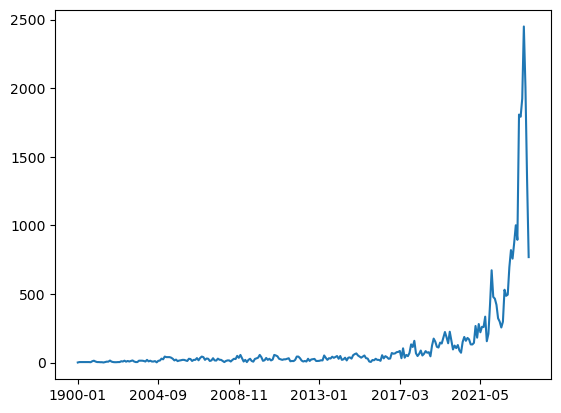

In [25]:
portfolio_res['open_month'].value_counts().sort_index().plot()

In [26]:
# 99 процентов занимают депозиты открытые позже 2017

portfolio_res[portfolio_res['open_month']>='2017-01']['balance'].sum() / portfolio_res['balance'].sum()

0.9998981367275538

### Джойним ftp ставки

In [27]:
# Код выгрузки

query = """
SELECT 
year(report_date) as report_year, 
month(report_date) as report_month, 
AVG(`vtb_[1095d]_ftp_rate`) as `VTB_[1095d]_ftp_rate`, 
AVG(`vtb_[180d]_ftp_rate`) as `VTB_[180d]_ftp_rate`,
AVG(`vtb_[365d]_ftp_rate`) as `VTB_[365d]_ftp_rate`,
AVG(`vtb_[548d]_ftp_rate`) as `VTB_[548d]_ftp_rate`,
AVG(`vtb_[730d]_ftp_rate`) as `VTB_[730d]_ftp_rate`,
AVG(`vtb_[90d]_ftp_rate`) as `VTB_[90d]_ftp_rate`

FROM dadm_alm_sbx.vtb_ftp_rates 

GROUP BY year(report_date), month(report_date)
ORDER BY year(report_date) desc, month(report_date) desc;
"""

In [28]:
ftp_table = pd.read_csv('ftp.csv')

In [29]:
ftp_table['report_month'][ftp_table['report_month']<=9] = ftp_table['report_month'][ftp_table['report_month']<=9].apply(lambda x: '0'+str(x))

In [30]:
ftp_table['report_month'] = ftp_table['report_month'].astype(str)

In [31]:
ftp_table['report_year'] = ftp_table['report_year'].astype(str)

In [32]:
ftp_table['open_month'] = ftp_table['report_year'] + '-' + ftp_table['report_month']

In [33]:
del ftp_table['report_month']
del ftp_table['report_year']

In [34]:
ftp_table

,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,open_month
0,12.000000,12.000000,12.000000,12.000000,12.000000,12.257143,2023-09
1,11.130435,10.760870,10.913043,10.934783,10.956522,10.706522,2023-08
2,9.642857,8.578571,8.821429,9.050000,9.278571,8.407143,2023-07
3,9.500000,8.350000,8.550000,8.850000,9.150000,8.100000,2023-06
4,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,2023-05
...,...,...,...,...,...,...,...
217,8.410000,5.980000,NaN,NaN,NaN,NaN,2005-05
218,8.830000,6.520000,NaN,NaN,NaN,NaN,2005-04
219,8.580000,6.670000,NaN,NaN,NaN,NaN,2005-03
220,8.990000,7.470000,NaN,NaN,NaN,NaN,2005-02


In [35]:
# дополнить этот момент
# для новых вкладов лучше брать новые ставки

portfolio_res['open_month'][portfolio_res['open_month']>'2023-09'] = '2023-09'

portfolio_res = portfolio_res.merge(ftp_table, on='open_month', how='left')

In [36]:
portfolio_res['ftp'] = np.nan



for day in portfolio_res['target_maturity_days'].unique():
    
    # выбираем колонку
    col = f'vtb_[{day}d]_ftp_rate'
    
    portfolio_res['ftp'][portfolio_res['target_maturity_days']==day] = portfolio_res[col][portfolio_res['target_maturity_days']==day]

In [37]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum()

1103469661.473421

In [38]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

7.535412691851977e-05

In [39]:
portfolio_res[portfolio_res['ftp'].isnull()]['open_month'].value_counts().sort_index()

1900-01     1
1993-12     4
1994-01     4
1997-12     4
1998-05     4
           ..
2017-08     4
2017-09    39
2017-10    79
2017-11    21
2017-12    35
Name: open_month, Length: 179, dtype: int64

формула для пролонгаций = дата открытия + срочность * число пролонгаций - это фактическая open_dt   

Можно подойти через плановая дата закрытия - срочность  

In [40]:
portfolio_res.head()

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name,renewal_balance_next_month,open_month_correct,target_maturity_months,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp
0,0,2023-08-31,mass,0,0,3,90,>2000k,5.0,2023-08,2023-11,10.221668,5.587933e+10,0.0,0.0,NaN,2023-08_2023-11_5.0_4.0_11.0_0_10000.0_RUR,NaN,2023-08-01,3,11.130435,10.760870,10.913043,10.934783,10.956522,10.706522,10.706522
1,1,2023-08-31,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479942,3.102769e+10,0.0,0.0,-2.957130e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,8.300000
2,2,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.472240,3.052281e+10,0.0,0.0,-1.910815e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,8.300000
3,3,2023-08-31,mass,0,0,12,365,1000k-2000k,4.0,2022-09,2023-09,7.000000,2.480401e+10,0.0,0.0,-1.934412e+08,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,NaN,2022-09-01,12,8.250000,7.891304,8.000000,8.100000,8.150000,7.847826,8.000000
4,4,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-06,2023-12,7.447860,1.788060e+10,0.0,0.0,-4.843801e+08,2023-06_2023-12_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-06-01,6,9.500000,8.350000,8.550000,8.850000,9.150000,8.100000,8.350000


In [41]:
agg_res.groupby('report_dt').sum()

,Unnamed: 0,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,balance_start,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal,universal_weight_id
report_dt,,,,,,,,,,,,,,,
2023-09-30,5294,32,27,1065,32373,3.295017e+12,3.364565e+11,3.631474e+12,7.608403e+11,-3.777930e+11,-4.511836e+10,-2.186902e+10,2.039656e+10,6.550854e+10,304
2023-10-31,8208,31,26,1041,31643,3.631474e+12,2.075367e+11,3.839010e+12,5.142912e+11,-2.880336e+11,-2.411135e+10,-1.986457e+10,2.525495e+10,4.261724e+10,294
2023-11-30,10780,30,25,1017,30913,3.839010e+12,3.927319e+10,3.878284e+12,8.075086e+11,-7.642714e+11,-2.114475e+10,-4.718331e+09,2.189902e+10,2.644586e+11,284


default_rates = scenario_df[FTP_RATES_].values*(1- scenario_df[FOR_].values/100) - scenario_df[MARGIN_].values - scenario_df[SSV_].values

In [42]:
portfolio_res['FOR'] = 4.5
portfolio_res['SSV'] = 0.48

In [43]:
portfolio_res['ftp'] = portfolio_res['ftp'] * (1 - portfolio_res['FOR']/100)

In [44]:
portfolio_res['ftp'] = portfolio_res['ftp'] - portfolio_res['SSV']

### The next step

Берем средневзвешанные ставки и взвешиваем еще раз но в разрезах agg_res

In [45]:
portfolio_res.head(3)

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name,renewal_balance_next_month,open_month_correct,target_maturity_months,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp,FOR,SSV
0,0,2023-08-31,mass,0,0,3,90,>2000k,5.0,2023-08,2023-11,10.221668,5.587933e+10,0.0,0.0,NaN,2023-08_2023-11_5.0_4.0_11.0_0_10000.0_RUR,NaN,2023-08-01,3,11.130435,10.76087,10.913043,10.934783,10.956522,10.706522,9.744728,4.5,0.48
1,1,2023-08-31,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479942,3.102769e+10,0.0,0.0,-2.957130e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.30000,8.550000,8.850000,9.150000,8.050000,7.446500,4.5,0.48
2,2,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.472240,3.052281e+10,0.0,0.0,-1.910815e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.30000,8.550000,8.850000,9.150000,8.050000,7.446500,4.5,0.48


In [46]:
agg_res.head(3)

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,balance_start,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal,universal_weight_id
0,57,2023-09-30,mass,0,0,3,90,1.922497e+11,7.202959e+10,2.642793e+11,8.205169e+10,-1.132872e+10,0.000000e+00,0.0,1.306627e+09,9.970162e+09,2
1,58,2023-09-30,mass,0,0,6,180,3.821177e+11,-3.768106e+10,3.444367e+11,6.013483e+10,-9.581471e+10,-3.802813e+09,0.0,1.801624e+09,8.841966e+07,3
2,59,2023-09-30,mass,0,0,12,365,2.852352e+11,-3.153587e+10,2.536994e+11,4.168403e+10,-7.249158e+10,-2.077828e+09,0.0,1.349506e+09,2.066099e+07,5


In [47]:
group_cols = ['report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'target_maturity_days']

In [48]:
tmp = portfolio_res.groupby(group_cols).sum()['balance'].reset_index()
tmp.head()

,report_dt,segment,replenishable_flg,subtraction_flg,target_maturity_days,balance
0,2023-08-31,mass,0,0,90,1.922497e+11
1,2023-08-31,mass,0,0,180,3.821177e+11
2,2023-08-31,mass,0,0,365,2.852352e+11
3,2023-08-31,mass,0,0,548,9.981288e+09
4,2023-08-31,mass,0,0,730,2.164728e+09


In [49]:
tmp.shape

(224, 6)

In [50]:
agg_res.shape

(171, 17)

In [51]:
tmp.rename(columns={'balance': 'balance_agg'}, inplace=True)

In [52]:
portfolio_res = portfolio_res.merge(tmp, on=group_cols, how='left')

In [53]:
portfolio_res['share'] = portfolio_res['balance'] / portfolio_res['balance_agg']

In [54]:
# portfolio_res['share'] 

In [55]:
portfolio_res['ftp_weighted'] = portfolio_res['share'] * portfolio_res['ftp']

In [56]:
portfolio_res['weight_rate_weighted'] = portfolio_res['share'] * portfolio_res['weight_rate']

In [57]:
portfolio_res

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name,renewal_balance_next_month,open_month_correct,target_maturity_months,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp,FOR,SSV,balance_agg,share,ftp_weighted,weight_rate_weighted
0,0,2023-08-31,mass,0,0,3,90,>2000k,5.0,2023-08,2023-11,10.221668,5.587933e+10,0.0,0.0,NaN,2023-08_2023-11_5.0_4.0_11.0_0_10000.0_RUR,NaN,2023-08-01,3,11.130435,10.760870,10.913043,10.934783,10.956522,10.706522,9.744728,4.5,0.48,1.922497e+11,2.906602e-01,2.832405e+00,2.971033e+00
1,1,2023-08-31,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479942,3.102769e+10,0.0,0.0,-2.957130e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,7.446500,4.5,0.48,3.821177e+11,8.119929e-02,6.046505e-01,6.073660e-01
2,2,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.472240,3.052281e+10,0.0,0.0,-1.910815e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-03-01,6,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,7.446500,4.5,0.48,3.821177e+11,7.987804e-02,5.948118e-01,5.968679e-01
3,3,2023-08-31,mass,0,0,12,365,1000k-2000k,4.0,2022-09,2023-09,7.000000,2.480401e+10,0.0,0.0,-1.934412e+08,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,NaN,2022-09-01,12,8.250000,7.891304,8.000000,8.100000,8.150000,7.847826,7.160000,4.5,0.48,2.852352e+11,8.695985e-02,6.226325e-01,6.087190e-01
4,4,2023-08-31,mass,0,0,6,180,400k-1000k,3.0,2023-06,2023-12,7.447860,1.788060e+10,0.0,0.0,-4.843801e+08,2023-06_2023-12_3.0_7.0_8.0_0_0_0.0_RUR,NaN,2023-06-01,6,9.500000,8.350000,8.550000,8.850000,9.150000,8.100000,7.494250,4.5,0.48,3.821177e+11,4.679342e-02,3.506816e-01,3.485109e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34525,34525,2023-11-30,vip,1,1,24,730,>2000k,5.0,2022-10,2024-10,4.500000,1.011292e+03,0.0,0.0,0.000000e+00,2022-10_2024-10_5.0_25.0_5.0_3_2_0.0_RUR,NaN,2022-10-01,24,9.500000,8.250000,8.550000,8.850000,9.150000,8.000000,8.258250,4.5,0.48,9.470093e+10,1.067880e-08,8.818820e-08,4.805460e-08
34526,34526,2023-11-30,vip,1,1,12,365,>2000k,5.0,2021-06,2024-06,0.010000,1.000385e+03,2.0,0.0,0.000000e+00,2021-06_2024-06_5.0_13.0_3.0_3_2_1.0_RUR,NaN,2019-07-31,12,6.822381,6.027619,6.207619,6.384762,6.561905,5.700476,5.448276,4.5,0.48,5.019618e+11,1.992950e-09,1.085814e-08,1.992950e-11
34527,34527,2023-11-30,vip,1,1,12,365,400k-1000k,3.0,2015-02,2024-02,0.010000,1.740044e+00,2.0,0.0,0.000000e+00,2015-02_2024-02_3.0_13.0_1.0_3_2_RUR,NaN,2013-03-31,12,17.104737,NaN,16.765789,NaN,16.922105,16.233684,15.531329,4.5,0.48,5.019618e+11,3.466486e-12,5.383913e-11,3.466486e-14
34528,34528,2023-11-30,vip,1,1,12,365,<100k,1.0,2009-11,2023-12,0.010000,1.110028e+00,2.0,0.0,0.000000e+00,2009-11_2023-12_1.0_13.0_1.0_3_2_RUR,NaN,2007-12-31,12,11.590000,10.663333,NaN,NaN,NaN,NaN,NaN,4.5,0.48,5.019618e+11,2.211379e-12,NaN,2.211379e-14


In [58]:
portfolio_res['ftp_weighted']

0        2.832405e+00
1        6.046505e-01
2        5.948118e-01
3        6.226325e-01
4        3.506816e-01
             ...     
34525    8.818820e-08
34526    1.085814e-08
34527    5.383913e-11
34528             NaN
34529    1.954144e-13
Name: ftp_weighted, Length: 34530, dtype: float64

In [59]:
ftp_tmp = portfolio_res.groupby(group_cols).sum()['ftp_weighted'].reset_index()

In [60]:
rate_tmp = portfolio_res.groupby(group_cols).sum()['weight_rate_weighted'].reset_index()

In [61]:
ftp_tmp

,report_dt,segment,replenishable_flg,subtraction_flg,target_maturity_days,ftp_weighted
0,2023-08-31,mass,0,0,90,9.117621
1,2023-08-31,mass,0,0,180,7.894826
2,2023-08-31,mass,0,0,365,7.667944
3,2023-08-31,mass,0,0,548,8.410540
4,2023-08-31,mass,0,0,730,8.474858
...,...,...,...,...,...,...
219,2023-11-30,vip,1,1,180,10.655136
220,2023-11-30,vip,1,1,365,10.458548
221,2023-11-30,vip,1,1,548,10.461625
222,2023-11-30,vip,1,1,730,10.576403


In [62]:
group_cols

['report_dt',
 'segment',
 'replenishable_flg',
 'subtraction_flg',
 'target_maturity_days']

In [63]:
agg_res = agg_res.merge(ftp_tmp, on=group_cols, how='left')

In [64]:
agg_res = agg_res.merge(rate_tmp, on=group_cols, how='left')

In [65]:
agg_res

,Unnamed: 0,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,balance_start,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal,universal_weight_id,ftp_weighted,weight_rate_weighted
0,57,2023-09-30,mass,0,0,3,90,1.922497e+11,7.202959e+10,2.642793e+11,8.205169e+10,-1.132872e+10,0.000000e+00,0.000000e+00,1.306627e+09,9.970162e+09,2,10.002573,9.587090
1,58,2023-09-30,mass,0,0,6,180,3.821177e+11,-3.768106e+10,3.444367e+11,6.013483e+10,-9.581471e+10,-3.802813e+09,0.000000e+00,1.801624e+09,8.841966e+07,3,8.557571,8.078642
2,59,2023-09-30,mass,0,0,12,365,2.852352e+11,-3.153587e+10,2.536994e+11,4.168403e+10,-7.249158e+10,-2.077828e+09,0.000000e+00,1.349506e+09,2.066099e+07,5,8.358742,8.081486
3,60,2023-09-30,mass,0,0,18,548,9.981288e+09,1.114042e+10,2.112171e+10,1.113942e+10,-5.765299e+07,-5.806438e+06,0.000000e+00,6.445923e+07,0.000000e+00,6,9.736748,9.002265
4,61,2023-09-30,mass,0,0,24,730,2.164728e+09,5.608914e+08,2.725619e+09,5.552280e+08,-5.580819e+06,-2.724603e+06,0.000000e+00,1.396877e+07,2.800074e+05,6,8.987571,8.225115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,223,2023-11-30,vip,1,1,36,1095,3.360797e+11,3.994178e+10,3.760215e+11,1.860966e+10,0.000000e+00,0.000000e+00,1.821462e+10,3.117493e+09,0.000000e+00,7,10.120447,11.159259
167,224,2023-09-30,vip,0,1,12,365,4.251756e+06,-4.251756e+06,0.000000e+00,0.000000e+00,-4.251756e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,NaN,NaN
168,225,2023-09-30,vip,1,0,12,365,3.336765e+04,-3.336765e+04,0.000000e+00,0.000000e+00,-3.336765e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,NaN,NaN
169,226,2023-10-31,mass,1,0,12,365,9.018246e+05,-9.018246e+05,0.000000e+00,0.000000e+00,-9.018246e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,NaN,NaN


In [66]:
# получаются отрицательные значения

agg_res['share'] = (agg_res['ftp_weighted'] / agg_res['weight_rate_weighted']) - 1

In [67]:
agg_res['share'] = agg_res['share'].abs()

In [68]:
agg_res['margin'] = agg_res['share'] * agg_res['interests']

In [69]:
agg_res.groupby('report_dt').sum()

,Unnamed: 0,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,balance_start,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal,universal_weight_id,ftp_weighted,weight_rate_weighted,share,margin
report_dt,,,,,,,,,,,,,,,,,,,
2023-09-30,5294,32,27,1065,32373,3.295017e+12,3.364565e+11,3.631474e+12,7.608403e+11,-3.777930e+11,-4.511836e+10,-2.186902e+10,2.039656e+10,6.550854e+10,304,487.948436,393.120233,27.170441,9.298273e+08
2023-10-31,8208,31,26,1041,31643,3.631474e+12,2.075367e+11,3.839010e+12,5.142912e+11,-2.880336e+11,-2.411135e+10,-1.986457e+10,2.525495e+10,4.261724e+10,294,487.335190,401.366366,23.182307,1.367244e+09
2023-11-30,10780,30,25,1017,30913,3.839010e+12,3.927319e+10,3.878284e+12,8.075086e+11,-7.642714e+11,-2.114475e+10,-4.718331e+09,2.189902e+10,2.644586e+11,284,501.557062,410.222857,24.338931,1.608393e+09


Идеи по улучшению:  
* считать не от процентов, а от баланса (помесячный доход с портфеля на основе ставок, разобратсья)
* выявить где weighted rate > ftp  и понять почему  

In [75]:
((agg_res.groupby('report_dt').sum()['margin'] / agg_res.groupby('report_dt').sum()['balance']) * 365 / 30.3) * 100

report_dt
2023-09-30    0.308439
2023-10-31    0.429019
2023-11-30    0.499577
dtype: float64